<a href="https://colab.research.google.com/github/Hung369/Language-Translator/blob/main/translation_EN_JP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets sentencepiece sacrebleu bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires 

In [ ]:
from datasets import load_dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, pipeline
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
bleu_metric = load_metric("sacrebleu", trust_remote_code=True)
bert_metric = load_metric("bertscore", trust_remote_code=True)

<ipython-input-3-96c84b8c030b>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu", trust_remote_code=True)


In [ ]:
data = load_dataset("kde4", lang1="en", lang2="ja", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Access the cache files of the 'train' split within the DatasetDict
cache_dir = data['train'].cache_files[0]['filename'].split('/kde4')[0]

# Function to calculate the size of the directory
def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is a symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

# Get the size in bytes
size_in_bytes = get_directory_size(cache_dir)

# Convert to MB
size_in_gb = size_in_bytes / (1024 * 1024)
print("Size of dataset (MB): ", size_in_gb)
print(data)

Size of dataset (MB):  28.815853118896484
DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 131429
    })
})


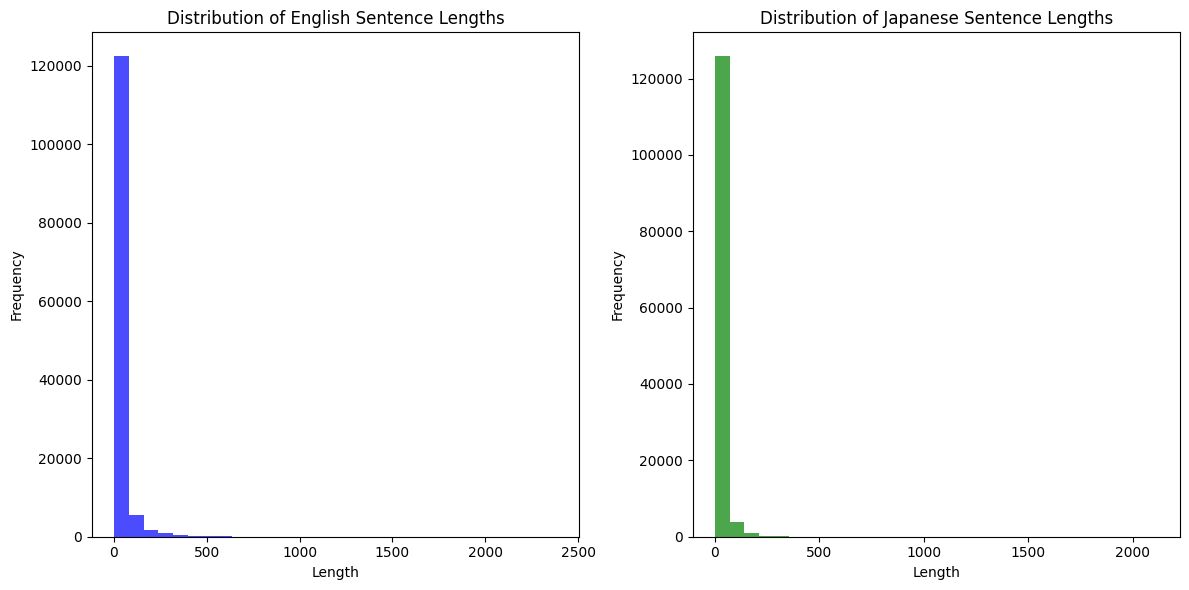

In [ ]:
# survey to choose max_length
dataset = data['train']

# Calculate sentence lengths
en_lengths = []
ja_lengths = []

for example in dataset:
    en_len = len(example['translation']['en'])  # number of characters in English sentence
    ja_len = len(example['translation']['ja'])  # number of characters in Japanese sentence
    en_lengths.append(en_len)
    ja_lengths.append(ja_len)

# Plot the distributions
plt.figure(figsize=(12, 6))

# Plot for English sentence lengths
plt.subplot(1, 2, 1)
plt.hist(en_lengths, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of English Sentence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Plot for Japanese sentence lengths
plt.subplot(1, 2, 2)
plt.hist(ja_lengths, bins=30, color='green', alpha=0.7)
plt.title('Distribution of Japanese Sentence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# split dataset into train, validation and test with ratio 0.8, 0.1 and 0.1 respectively
train_testvalid = data['train'].train_test_split(test_size=0.2) # Changed 'test' to 'test_size'
test_valid = train_testvalid["test"].train_test_split(test_size=0.5)

train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']}
)

In [ ]:
print(train_test_valid_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 105143
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 13143
    })
    valid: Dataset({
        features: ['id', 'translation'],
        num_rows: 13143
    })
})


In [ ]:
checkpoint = "Hoax0930/marian-finetuned-kde4-en-to-ja"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/808k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/834k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/310M [00:00<?, ?B/s]

In [ ]:
max_input_len = 500
max_target_len = 500

def tokenizer_fn(batch):
  inputs = [x['en'] for x in batch['translation']]
  targets = [x['ja'] for x in batch['translation']]

  tokenized_inputs = tokenizer(inputs, max_length=max_input_len, truncation=True)

  tokenized_targets = tokenizer(text_target=targets, max_length=max_target_len, truncation=True)

  tokenized_inputs['labels'] = tokenized_targets['input_ids']
  return tokenized_inputs

In [ ]:
train_dataset, test_dataset, val_dataset = train_test_valid_dataset['train'], train_test_valid_dataset['test'], train_test_valid_dataset['valid']
tokenized_train = train_dataset.map(tokenizer_fn, batched=True, remove_columns=train_dataset.column_names)
tokenized_test = test_dataset.map(tokenizer_fn, batched=True, remove_columns=test_dataset.column_names)
tokenized_val = val_dataset.map(tokenizer_fn, batched=True, remove_columns=val_dataset.column_names)

Map:   0%|          | 0/105143 [00:00<?, ? examples/s]

Map:   0%|          | 0/13143 [00:00<?, ? examples/s]

Map:   0%|          | 0/13143 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
  preds, labels = preds_and_labels

  # convert predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  # for any -100 label, replace with pad token id
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  # convert labels into words
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # get rid of extraneous whitespace
  # and also, put targets into lists
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bleu = bleu_metric.compute(
      predictions=decoded_preds, references=decoded_labels)
  bert_score = bert_metric.compute(
      predictions=decoded_preds, references=decoded_labels, lang='fr')

  return {"bleu": bleu["score"], 'bert_score': np.mean(bert_score['f1'])}

In [ ]:
training_args = Seq2SeqTrainingArguments(
  "finetuned_translation_model",
  eval_strategy="epoch",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  weight_decay=0.01,
  num_train_epochs=4,
  predict_with_generate=True,
  fp16=True
)

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

eval_result = trainer.evaluate(eval_dataset=tokenized_test)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Bleu,Bert Score
1,1.130100,0.941284,35.205278,0.890680
2,0.978000,0.917376,35.679361,0.892360
3,0.904300,0.906021,36.139102,0.892727


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[65000]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[65000]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strate

In [ ]:
print(eval_result)

{'eval_loss': 0.9235560894012451, 'eval_bleu': 34.60858727021701, 'eval_bert_score': 0.8919993285867782, 'eval_runtime': 937.0719, 'eval_samples_per_second': 14.026, 'eval_steps_per_second': 0.439, 'epoch': 3.0}


In [ ]:
trainer.save_model("my_model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[65000]], 'forced_eos_token_id': 0}


In [ ]:
translator = pipeline("translation", model='my_model', device=0)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
translator("You are absolutely unique, just like everyone else.")

[{'translation_text': '他の人と同じように、あなたは本当にユニークです。'}]